In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.autograd import grad

In [2]:
def calc_grad(inp, out):
    return grad(out, inp, 
                grad_outputs = torch.ones_like(out),
                create_graph=True)[0]

In [3]:
class Net(nn.Module):

    def __init__(self, num_hidden, num_features, num_output):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden, num_hidden)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden), 0))
        # hidden layer
        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        # self.activation = torch.nn.ELU()
        self.activation = torch.nn.Tanh()
        # self.activation = torch.nn.ReLU()
        # self.activation = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.batchnorm = nn.BatchNorm1d(num_hidden, affine=False)
        
    def forward(self, x):
        #x = torch.stack((x,y),axis=1)
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        # x = self.dropout(x) 
        # x = self.batchnorm(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        # x = self.dropout(x)
        # x = self.batchnorm(x)
        
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        # x = self.dropout(x)
        # x = self.batchnorm(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        # x = self.dropout(x) 
        
        # x = F.linear(x, self.W_2, self.b_2)
        # x = self.activation(x)
        
        x = F.linear(x, self.W_3, self.b_3)
        # x = self.activation(x)
        return x

In [4]:
alpha = 0.2
beta = 0.05
gamma = 0.01

total  [2.04643018e+05 1.47928048e+03 3.99489808e+06 7.98979617e+05]
total  5000000.000000002


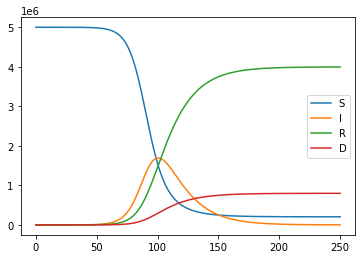

In [5]:
import ODE_SIR
solver = ODE_SIR.ODESolver()
t, wsol, N = solver.solve_SIRD(alpha, beta, gamma)
solver.plot_SIRD(t, wsol)

In [6]:
S_sol, I_sol, R_sol, D_sol = wsol[:,0], wsol[:,1], wsol[:,2], wsol[:,3]
init_num_people = np.sum(wsol[0,:])

In [7]:
t = torch.tensor(t, requires_grad=True).reshape(len(t),1).float()
S_sol = torch.tensor(S_sol, requires_grad=True).reshape(len(S_sol),1).float()
I_sol = torch.tensor(I_sol, requires_grad=True).reshape(len(I_sol),1).float()
R_sol = torch.tensor(R_sol, requires_grad=True).reshape(len(R_sol),1).float()
D_sol = torch.tensor(D_sol, requires_grad=True).reshape(len(D_sol),1).float()
init_num_people = torch.tensor(init_num_people).float()

In [8]:
num_hidden, num_features, num_output = 50, 1, 1

S_net = Net(num_hidden, num_features, num_output)
I_net = Net(num_hidden, num_features, num_output)
R_net = Net(num_hidden, num_features, num_output)
D_net = Net(num_hidden, num_features, num_output)

t_train = t

get_slice = lambda i, size: range(i * size, (i + 1) * size)
num_samples_train = t_train.shape[0]
batch_size = 100
num_batches_train = num_samples_train // batch_size

In [9]:
num_epochs = 100
S_optimizer = optim.Adam(S_net.parameters(), lr=0.1)
I_optimizer = optim.Adam(I_net.parameters(), lr=0.1)
R_optimizer = optim.Adam(R_net.parameters(), lr=0.1)
D_optimizer = optim.Adam(D_net.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [10]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []

losses = []
for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    S_net.train()
    I_net.train()
    R_net.train()
    D_net.train()
    
    for i in range(num_batches_train):
        S_optimizer.zero_grad()
        I_optimizer.zero_grad()
        R_optimizer.zero_grad()
        D_optimizer.zero_grad()

        slce = get_slice(i, batch_size)
        t_batch = t_train[slce]
        
        S = S_net(t_batch)
        S = S.reshape(S.shape[0])
        St = calc_grad(t_batch, S)
        
        I = I_net(t_batch)
        I = I.reshape(I.shape[0])
        It = calc_grad(t_batch, I)
        
        R = R_net(t_batch)
        R = R.reshape(R.shape[0])
        Rt = calc_grad(t_batch, R)
        
        D = D_net(t_batch)
        D = D.reshape(D.shape[0])
        Dt = calc_grad(t_batch, D)
        
        #S_rhs = -(alpha/N)*S*I
        #I_rhs = (alpha/N)*S*I-beta*I-gamma*I
        
        S_rhs = -alpha*S*I
        I_rhs = alpha*S*I-beta*I-gamma*I
        R_rhs = beta*I
        D_rhs = gamma*I
        
        num_people = (S + I + R + D).reshape(S.shape)
        target_num_people = torch.ones((S.shape[0],1))# * init_num_people
        
        output = torch.cat((S_rhs, I_rhs, R_rhs, D_rhs, num_people))
        
        target_batch = torch.cat((St, It, Rt, Dt, target_num_people))
        
        batch_loss = criterion(output.flatten(), 
                               target_batch.flatten(),
                               )
        batch_loss.backward()#retain_graph=True)
        
        S_optimizer.step()
        I_optimizer.step()
        R_optimizer.step()
        D_optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)
        
    if epoch%10==0:
        print("Epoch %2i : Train Loss %f" % (
            epoch+1, losses[-1]))

Epoch  1 : Train Loss 0.894838
Epoch 11 : Train Loss 0.000395
Epoch 21 : Train Loss 0.000000
Epoch 31 : Train Loss 0.000000
Epoch 41 : Train Loss 0.000000
Epoch 51 : Train Loss 0.000000
Epoch 61 : Train Loss 0.000000
Epoch 71 : Train Loss 0.000000
Epoch 81 : Train Loss 0.000000
Epoch 91 : Train Loss 0.011131


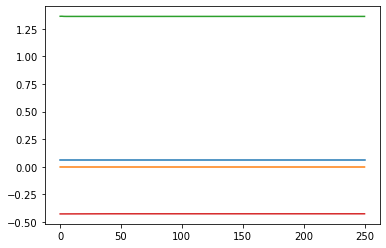

In [11]:
plt.plot(t.flatten().detach(), S_net(t).flatten().detach())
plt.plot(t.flatten().detach(), I_net(t).flatten().detach())
plt.plot(t.flatten().detach(), R_net(t).flatten().detach())
plt.plot(t.flatten().detach(), D_net(t).flatten().detach())

In [12]:
output
#target_batch

tensor([-8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0721e-06,
        -8.0721e-06, -8.0721e-06, -8.0721e-06, -8.0